# Classification with PyTorch/TensorFlow

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

## Part 1: Iris Classification

Iris Dataset contains 150 records of 3 different classes of irises. Each record contains 4 numeric parameters: sepal length/width and petal length/width. It is an example of a simple dataset, for which you do not need a powerful neural network.

### Getting the Dataset

Iris dataset is build into Scikit Learn, so we can easily get it:

In [22]:
from sklearn.datasets import load_iris
#from sklearn.model_selection import train_test_split

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


### Visualize the Data

In many cases, it makes sense to visualize the data to see if they look separable - it would assure us that we should be able to build good classification model. Because we have a few features, we can build a series of pairwise 2D scatter plots, showing different classes by different dot colors. This can be automatically done by a package called **seaborn**:

In [23]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


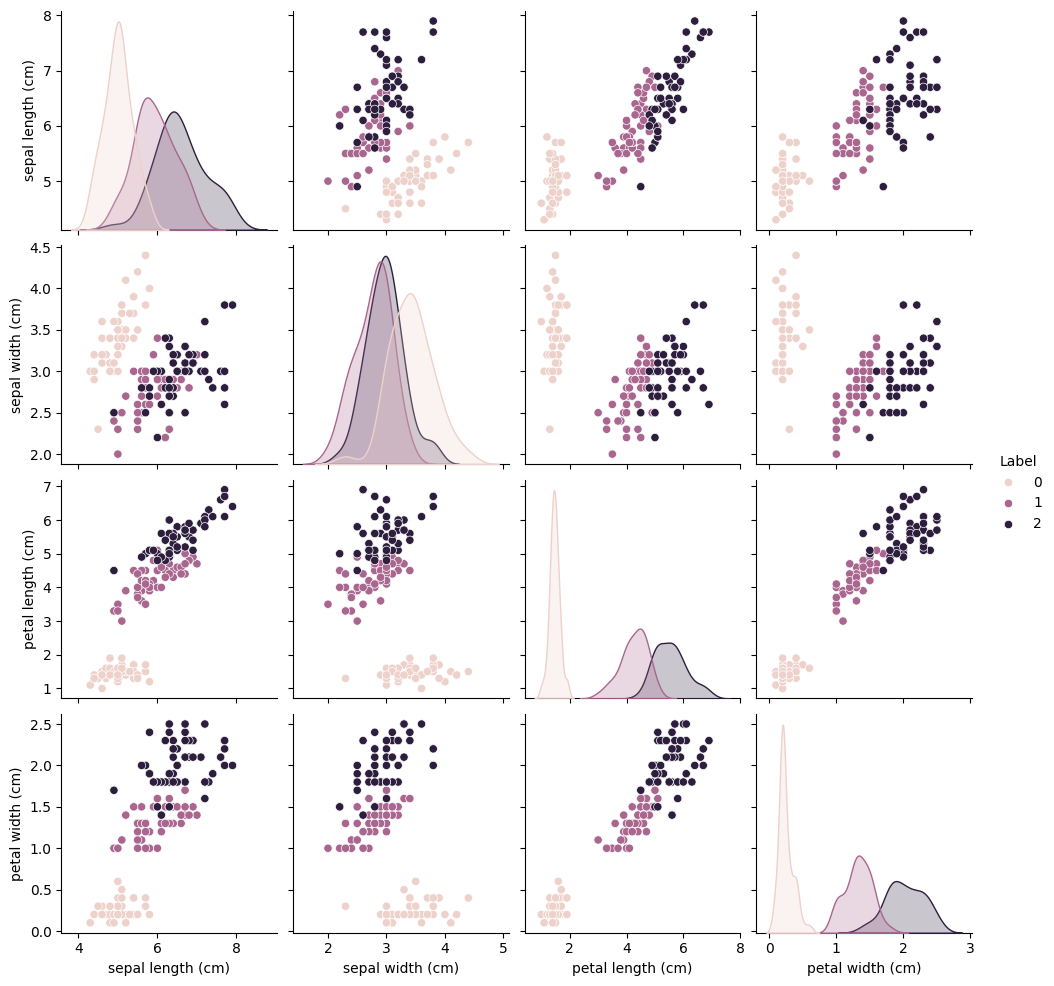

In [24]:
sns.pairplot(df,hue='Label')

### Normalize and Encode the Data

To prepare data to neural network training, we need to normalize inputs in the range [0,1]. We do this using plain `numpy` operations.

Since PyTorch allows you to feed in class number  as an integer (from 0 to N-1) we do not transform the labels. After transforming the normalized features and labels into PyTorch tensors we load it into a Dataset class.
``` 

In [25]:
import torch
import torch.utils.data as data_utils
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

features_max = features.max(axis=0, keepdims=True)
features_min = features.min(axis=0, keepdims=True)
normalized_features = (features-features_min)/(features_max-features_min)

features_tensor = torch.Tensor(normalized_features)
labels_tensor = torch.Tensor(labels).type(torch.LongTensor)
dataset = data_utils.TensorDataset(features_tensor, labels_tensor)


### Split the Data into Train and Test

We still need to split the dataset in train data and test data. We use the `random_split` function in PyTorch for this.

In [26]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = data_utils.random_split(dataset,[train_size, test_size])

batch_size = 10
train_loader = data_utils.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = data_utils.DataLoader(test_data, batch_size=10, shuffle=True)

In [27]:
for features, labels in train_loader:
    print(features.shape)

torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])


### Define and Train Neural Network

The assignment suggested that we use a neural network with one, two or three layers. These are implemented below. We chose to use relatively large hidden layers, as these seem to give good results.

In [28]:
class OneLayerNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,3)

    def forward(self, x):
        x=self.linear1(x)
        return x
    
class TwoLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,50)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(50,3)

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return x
    
class ThreeLayernet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,50)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(50,50)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(50,3)

    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear2(x))
        x = self.linear3(x)
        return x

The following two funtions implement the training loop. One function trains the model for one epoch and the other function implements the whole training cycle.

In [29]:
def train_epoch(model, loss_fn, dataloader, optimizer, report_freq):
    epoch_loss=[]
    running_loss = 0.0
    for j, data in enumerate(dataloader):
            features, labels = data

            optimizer.zero_grad()

            preds = model(features)
            batch_loss = loss_fn(preds, labels)
            batch_loss.backward()
            optimizer.step()

            epoch_loss.append(batch_loss.item())
            running_loss+=batch_loss.item()
            if j%report_freq==report_freq-1:
                print(f"batch {j+1}, loss: {running_loss/report_freq}")
                running_loss = 0.0
    return epoch_loss

def train_model(model, loss_fn,train_loader, test_loader, optimizer,no_of_epochs, report_freq):
    train_loss = []
    val_loss = []
    accuracy = []
    epoch_number = 1
    for epoch in range(no_of_epochs):
        #epoch_loss = []
        print(f"EPOCH {epoch_number}:")
        model.train(True)
        epoch_loss = train_epoch(model,loss_fn, train_loader, optimizer, report_freq)
        train_loss+=epoch_loss
            
        running_vloss = 0.0
        model.eval()
        with torch.no_grad():
             for i, vdata in enumerate(test_loader):
                  vfeatures, vlabels = vdata
                  vpred = model(vfeatures)
                  vloss = loss_fn(vpred,vlabels)
                  correct = (torch.argmax(vpred, dim=1) == vlabels).type(torch.FloatTensor)
                  val_loss.append(vloss.item())
                  running_vloss+=vloss.item()
                  accuracy.append(correct.mean().item())
        

        val_loss.append(running_vloss/(i+1))
        train_loss+=epoch_loss
        print(f"LOSS train {epoch_loss[-1]}, val: {val_loss[-1]}")

        epoch_number+=1
    return train_loss, val_loss, accuracy
    

Now we are ready to train the models. We will train for 50 epochs.

In [30]:
no_of_epochs = 50
net1 = OneLayerNet()
loss_fn = torch.nn.CrossEntropyLoss()
optim1 = torch.optim.SGD(net1.parameters(), lr=0.01, momentum=0.9)

train_loss1, val_loss1, acc1 = train_model(net1,loss_fn,train_loader,test_loader,optim1, no_of_epochs, report_freq=5)


EPOCH 1:
batch 5, loss: 1.3945933818817138
batch 10, loss: 1.2265574932098389
LOSS train 1.039269208908081, val: 1.2066700458526611
EPOCH 2:
batch 5, loss: 1.1952152490615844
batch 10, loss: 1.0376392364501954
LOSS train 1.0674302577972412, val: 1.0549177130063374
EPOCH 3:
batch 5, loss: 1.0419018030166627
batch 10, loss: 0.92278151512146
LOSS train 1.0247670412063599, val: 0.9742743770281473
EPOCH 4:
batch 5, loss: 0.9456723928451538
batch 10, loss: 0.9122718811035156
LOSS train 0.893985390663147, val: 0.9184159835179647
EPOCH 5:
batch 5, loss: 0.8683098554611206
batch 10, loss: 0.8960622191429138
LOSS train 0.8570316433906555, val: 0.8795239130655924
EPOCH 6:
batch 5, loss: 0.8383202075958252
batch 10, loss: 0.8352816462516784
LOSS train 0.7935450673103333, val: 0.8436871767044067
EPOCH 7:
batch 5, loss: 0.7788632392883301
batch 10, loss: 0.8234345078468323
LOSS train 0.8232516050338745, val: 0.814125657081604
EPOCH 8:
batch 5, loss: 0.7773221254348754
batch 10, loss: 0.7573858141899

batch 5, loss: 0.6296009540557861
batch 10, loss: 0.6110039114952087
LOSS train 0.6158785223960876, val: 0.6445503234863281
EPOCH 17:
batch 5, loss: 0.5865234971046448
batch 10, loss: 0.6483381032943726
LOSS train 0.5770982503890991, val: 0.6331512133280436
EPOCH 18:
batch 5, loss: 0.5993786931037903
batch 10, loss: 0.5820598006248474
LOSS train 0.5379261374473572, val: 0.6220418413480123
EPOCH 19:
batch 5, loss: 0.587696373462677
batch 10, loss: 0.5691445827484131
LOSS train 0.6181685328483582, val: 0.6134081780910492
EPOCH 20:
batch 5, loss: 0.6250059962272644
batch 10, loss: 0.5301441073417663
LOSS train 0.657524824142456, val: 0.6039084295431772
EPOCH 21:
batch 5, loss: 0.6025858283042907
batch 10, loss: 0.5345956027507782
LOSS train 0.5377445220947266, val: 0.594150980313619
EPOCH 22:
batch 5, loss: 0.5654061198234558
batch 10, loss: 0.5603315472602844
LOSS train 0.4240475296974182, val: 0.5858999490737915
EPOCH 23:
batch 5, loss: 0.5278730750083923
batch 10, loss: 0.5569328546524

In [31]:
no_of_epochs = 50
net2 = TwoLayerNet()
optim2 = torch.optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)

train_loss2, val_loss2, acc2 = train_model(net2,loss_fn,train_loader,test_loader,optim2, no_of_epochs, report_freq=5)

EPOCH 1:
batch 5, loss: 1.086130404472351
batch 10, loss: 1.0302522659301758
LOSS train 1.0481226444244385, val: 1.0142828822135925
EPOCH 2:
batch 5, loss: 0.9572259664535523
batch 10, loss: 0.935095751285553
LOSS train 0.8435319066047668, val: 0.8899922768274943
EPOCH 3:
batch 5, loss: 0.8276718378067016
batch 10, loss: 0.8175714015960693
LOSS train 0.7007112503051758, val: 0.7795419692993164
EPOCH 4:
batch 5, loss: 0.7282239913940429
batch 10, loss: 0.6941400766372681
LOSS train 0.6519924998283386, val: 0.6845887700716654
EPOCH 5:
batch 5, loss: 0.5929927587509155
batch 10, loss: 0.636016595363617
LOSS train 0.5861173868179321, val: 0.6136611501375834
EPOCH 6:
batch 5, loss: 0.5002420544624329
batch 10, loss: 0.5657974362373352
LOSS train 0.5286566019058228, val: 0.5587902367115021
EPOCH 7:
batch 5, loss: 0.46836690306663514
batch 10, loss: 0.5528520405292511
LOSS train 0.5079984068870544, val: 0.5148409903049469
EPOCH 8:
batch 5, loss: 0.46789132356643676
batch 10, loss: 0.462472701

In [32]:
no_of_epochs = 50
net3 = ThreeLayernet()
#loss_fn = torch.nn.CrossEntropyLoss()
optim3 = torch.optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)

train_loss3, val_loss3, acc3 = train_model(net3,loss_fn,train_loader,test_loader,optim3, no_of_epochs, report_freq=5)

EPOCH 1:
batch 5, loss: 1.1098868608474732
batch 10, loss: 1.0935606002807616
LOSS train 1.068770408630371, val: 1.076177438100179
EPOCH 2:
batch 5, loss: 1.0615042686462401
batch 10, loss: 1.0423696041107178
LOSS train 0.9767290353775024, val: 1.0352622469266255
EPOCH 3:
batch 5, loss: 1.0254210710525513
batch 10, loss: 0.9521528482437134
LOSS train 0.9691168665885925, val: 0.9732349514961243
EPOCH 4:
batch 5, loss: 0.9229861855506897
batch 10, loss: 0.8963272213935852
LOSS train 0.8422031402587891, val: 0.8806204398473104
EPOCH 5:
batch 5, loss: 0.8038285851478577
batch 10, loss: 0.7942839026451111
LOSS train 0.6737805008888245, val: 0.7537287473678589
EPOCH 6:
batch 5, loss: 0.6811999440193176
batch 10, loss: 0.6335925817489624
LOSS train 0.5137625932693481, val: 0.6247703035672506
EPOCH 7:
batch 5, loss: 0.5767566919326782
batch 10, loss: 0.5081551492214202
LOSS train 0.48948612809181213, val: 0.5231887400150299
EPOCH 8:
batch 5, loss: 0.429966527223587
batch 10, loss: 0.4438129067

### Plot of results

Below we plot the training and validation loss as well as the accuracy of the classification. All models show good convergence with increasing performance as the number of layers increases.

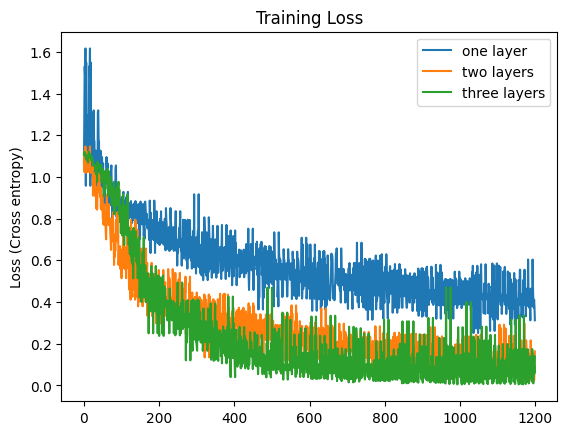

In [33]:
from matplotlib import pyplot as plt
plt.plot(train_loss1, label='one layer')
plt.plot(train_loss2, label='two layers')
plt.plot(train_loss3, label='three layers')
plt.ylabel("Loss (Cross entropy)")
plt.title("Training Loss")
plt.legend()


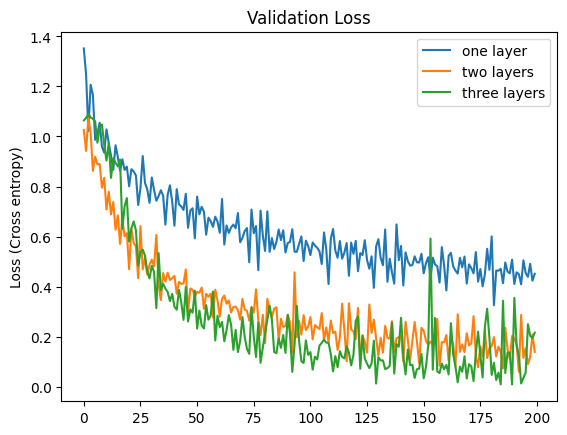

In [34]:
plt.plot(val_loss1, label='one layer')
plt.plot(val_loss2, label='two layers')
plt.plot(val_loss3, label='three layers')
plt.ylabel("Loss (Cross entropy)")
plt.title("Validation Loss")
plt.legend()

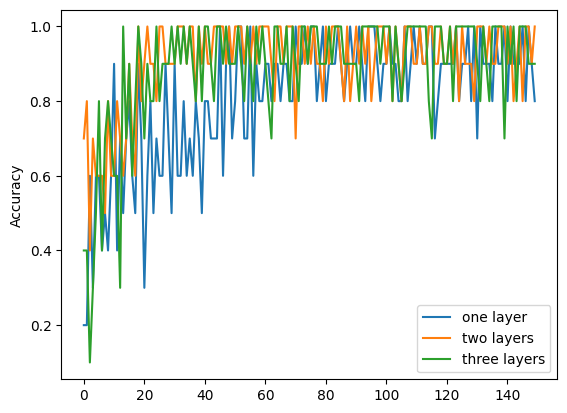

In [35]:
from matplotlib import pyplot as plt
plt.plot(acc1, label='one layer')
plt.plot(acc2, label='two layers')
plt.plot(acc3, label='three layers')
plt.ylabel("Accuracy")
#plt.title("Training Loss")
plt.legend()

## Part 2: MNIST Training

Both Keras and PyTorch contain MNIST as built-in dataset, we use PyTorch to download the dataset.

In [36]:
import torchvision
import torchvision.transforms as tf

transform = tf.ToTensor()

mnist_dataset_train = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
mnist_dataset_test = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)

batch_size=100
mnist_train_loader = data_utils.DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = data_utils.DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

Just as before we define three different models with one, two and three layers respectively.

In [37]:
class MNISTOneLayerNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(784,10)

    def forward(self, x):
        x = self.flatten(x)# make sure the data has the right input dimension
        return self.linear1(x)
    
class MNISTTwoLayerNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(784,1024)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(1024,10)

    def forward(self, x):
        x = self.flatten(x)# make sure the data has the right input dimension
        x = self.activation1(self.linear1(x))
        return self.linear2(x)
    
class MNISTThreeLayerNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(784,1024)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(1024,1024)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(1024,10)

    def forward(self, x):
        x = self.flatten(x)# make sure the data has the right input dimension
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear2(x))
        return self.linear3(x)
    

We start training now. Since the dataset is larger we use a lower number of epochs. This seems to be sufficient for a good performance.

In [38]:
no_of_epochs = 5
net1 = MNISTOneLayerNet()
loss_fn = torch.nn.CrossEntropyLoss()
optim1 = torch.optim.SGD(net1.parameters(), lr=0.01, momentum=0.9)

train_loss1, val_loss1, acc1 = train_model(net1,loss_fn, mnist_train_loader, mnist_test_loader, optim1, no_of_epochs,report_freq=100)

EPOCH 1:
batch 100, loss: 1.0353581708669664
batch 200, loss: 0.5250325351953506
batch 300, loss: 0.46001021951437
batch 400, loss: 0.44275088906288146
batch 500, loss: 0.4179887712001801
batch 600, loss: 0.37892783984541895
LOSS train 0.5217937231063843, val: 0.36278579995036125
EPOCH 2:
batch 100, loss: 0.36841833040118216
batch 200, loss: 0.36816558092832563
batch 300, loss: 0.36678247183561324
batch 400, loss: 0.35309475272893903
batch 500, loss: 0.3474672129750252
batch 600, loss: 0.34545322105288506
LOSS train 0.4270137548446655, val: 0.32339598670601843
EPOCH 3:
batch 100, loss: 0.34416371181607247
batch 200, loss: 0.30853700518608096
batch 300, loss: 0.33429119750857356
batch 400, loss: 0.34567277163267135
batch 500, loss: 0.32857652232050893
batch 600, loss: 0.3229335755109787
LOSS train 0.49500682950019836, val: 0.3065260544419289
EPOCH 4:
batch 100, loss: 0.32959753945469855
batch 200, loss: 0.32123174995183945
batch 300, loss: 0.3201347382366657
batch 400, loss: 0.315679419

In [39]:
no_of_epochs = 5
net2 = MNISTTwoLayerNet()
loss_fn = torch.nn.CrossEntropyLoss()
optim2 = torch.optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)

train_loss2, val_loss2, acc2 = train_model(net2,loss_fn, mnist_train_loader, mnist_test_loader, optim2, no_of_epochs,report_freq=100)

EPOCH 1:
batch 100, loss: 1.2503915259242058
batch 200, loss: 0.4809970107674599
batch 300, loss: 0.3828975009918213
batch 400, loss: 0.3369895660877228
batch 500, loss: 0.3138558694720268
batch 600, loss: 0.31335556104779244
LOSS train 0.33888301253318787, val: 0.28019490867853164
EPOCH 2:
batch 100, loss: 0.2903213685750961
batch 200, loss: 0.286546411216259
batch 300, loss: 0.2657629023492336
batch 400, loss: 0.24455805614590645
batch 500, loss: 0.22959329664707184
batch 600, loss: 0.21464174278080464
LOSS train 0.2178725302219391, val: 0.21127232678234578
EPOCH 3:
batch 100, loss: 0.22333440966904164
batch 200, loss: 0.20655026406049729
batch 300, loss: 0.20002826623618603
batch 400, loss: 0.1870020841062069
batch 500, loss: 0.19539385959506034
batch 600, loss: 0.1811848946660757
LOSS train 0.12226250767707825, val: 0.17436611719429493
EPOCH 4:
batch 100, loss: 0.1717748661339283
batch 200, loss: 0.17319218952208756
batch 300, loss: 0.16741761963814497
batch 400, loss: 0.1533790751

In [40]:
no_of_epochs = 5
net3 = MNISTThreeLayerNet()
loss_fn = torch.nn.CrossEntropyLoss()
optim3 = torch.optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)

train_loss3, val_loss3, acc3 = train_model(net3,loss_fn, mnist_train_loader, mnist_test_loader, optim3, no_of_epochs,report_freq=100)

EPOCH 1:
batch 100, loss: 1.6352170157432555
batch 200, loss: 0.5140735101699829
batch 300, loss: 0.3810766576230526
batch 400, loss: 0.3366216719895601
batch 500, loss: 0.30479915738105773
batch 600, loss: 0.29245461359620095
LOSS train 0.3260127604007721, val: 0.2553428383171558
EPOCH 2:
batch 100, loss: 0.2663592092692852
batch 200, loss: 0.24762932144105435
batch 300, loss: 0.23503438755869865
batch 400, loss: 0.20957616575062274
batch 500, loss: 0.19142604939639568
batch 600, loss: 0.18804515540599823
LOSS train 0.27350863814353943, val: 0.17725051380693913
EPOCH 3:
batch 100, loss: 0.17294911675155164
batch 200, loss: 0.16811073396354914
batch 300, loss: 0.15991714265197515
batch 400, loss: 0.1470555841177702
batch 500, loss: 0.1491445069015026
batch 600, loss: 0.13342364031821488
LOSS train 0.05575232580304146, val: 0.12608045134693385
EPOCH 4:
batch 100, loss: 0.1224148003757
batch 200, loss: 0.13112202484160662
batch 300, loss: 0.11180521961301565
batch 400, loss: 0.1198241615

Now we plot the loss and accuracy.

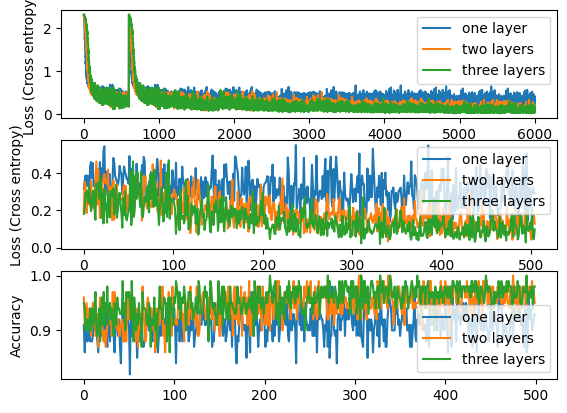

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

ax1.plot(train_loss1, label='one layer')
ax1.plot(train_loss2, label='two layers')
ax1.plot(train_loss3, label='three layers')
ax1.set_ylabel("Loss (Cross entropy)")
#ax1.title("Validation Loss")
ax1.legend()

ax2.plot(val_loss1, label='one layer')
ax2.plot(val_loss2, label='two layers')
ax2.plot(val_loss3, label='three layers')
ax2.set_ylabel("Loss (Cross entropy)")
#ax1.title("Validation Loss")
ax2.legend()

ax3.plot(acc1, label='one layer')
ax3.plot(acc2, label='two layers')
ax3.plot(acc3, label='three layers')
ax3.set_ylabel("Accuracy")
#plt.title("Training Loss")
ax3.legend()
plt.show()


## Takeaway

1. Neural networks can be used for traditional machine learning tasks. However, they are in many cases too powerful, and can cause overfitting.
1. It is important in this assignment that you observe the overfitting behavior, and try to avoid it.
1. With frameworks like Keras, sometimes training a neural network is quite straightforward. But you need to understand what goes on.